# IMPORTS

In [14]:
import os
import random
import time
import json
from datetime import datetime
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# SETUP PATHS

In [15]:
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

baseline_model_path = '/kaggle/input/trainresult-of-baseline-model/baseline_model (1).keras'
baseline_results_path = '/kaggle/input/trainresult-of-baseline-model/results_summary.json'

In [16]:
print(f"Dataset directory exists: {os.path.exists(dataset_path)}")
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")

Dataset directory exists: True
Training directory exists: True
Testing directory exists: True


In [17]:
baseline_available = os.path.exists(baseline_model_path)
print(f"\n Baseline model available: {baseline_available}")

if not baseline_available:
    print("To use the baseline model from Notebook 1:")
    print("1. Run the baseline notebook first")
    print("2. In THIS notebook, click 'Add Data' → 'Your Datasets'")
    print("3. Select the output from your baseline notebook")
    print("4. The baseline model will be available for comparison")
else:
    print(f" Baseline model found at: {baseline_model_path}")
    
    # Load baseline results if available
    if os.path.exists(baseline_results_path):
        with open(baseline_results_path, 'r') as f:
            baseline_results = json.load(f)
        print(f" Baseline test accuracy: {baseline_results['test_accuracy']*100:.2f}%")
        print(f" Baseline best val accuracy: {baseline_results['best_val_accuracy']*100:.2f}%")


 Baseline model available: True
 Baseline model found at: /kaggle/input/trainresult-of-baseline-model/baseline_model (1).keras
 Baseline test accuracy: 77.65%
 Baseline best val accuracy: 78.36%


# DATA GENERATORS

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nDataset Summary:")
print(f"Training samples: {train.samples}")
print(f"Validation samples: {val.samples}")
print(f"Testing samples: {test.samples}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Dataset Summary:
Training samples: 4857
Validation samples: 855
Testing samples: 1311


# HELPER FUNCTIONS

In [33]:
def create_cnn_model(filters=[64, 128, 256],
                     dropout_rate=0.5,
                     l2_reg=0.001,
                     dense_units=256,
                     input_shape=(128, 128, 3),
                     num_classes=4,
                     use_global_pooling=True): 
    """Create CNN model for brain tumor classification"""
    model = Sequential(name='BrainTumorCNN')
    
    model.add(Conv2D(filters[0], (3, 3), activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.4))
    
    model.add(Conv2D(filters[1], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    model.add(Conv2D(filters[2], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.8))
    
    if use_global_pooling:
        from tensorflow.keras.layers import GlobalAveragePooling2D
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())
    
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units // 2, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [20]:
def train_and_evaluate(model, train_gen, val_gen,
                       learning_rate=0.001,
                       optimizer_type='adam',
                       epochs=50,
                       patience=10,
                       verbose=0):
    """Train model and return validation accuracy"""
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        mode='max',
        verbose=0
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=1e-6,
        verbose=0
    )
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler],
        verbose=verbose
    )
    training_time = time.time() - start_time
    
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    return history, best_val_acc, training_time, best_epoch

In [21]:
def evaluate_model(model, test_gen, class_names, model_name="Model"):
    """Evaluate model on test set"""
    print(f"EVALUATING {model_name.upper()}")
    
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")
    print(f" Test Loss: {test_loss:.4f}")
    
    print("CLASSIFICATION REPORT")
    report = classification_report(y_true, y_pred_classes,
                                   target_names=class_names,
                                   digits=4)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    print("PER-CLASS ACCURACY")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name:15s}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'predictions': y_pred_classes,
        'probabilities': y_pred_probs,
        'true_labels': y_true
    }

In [22]:
def plot_training_history(history, title="Training History"):
    """Plot training history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs_range, acc, 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_acc, 'r-s', label='Validation', linewidth=2, markersize=4)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label='Best')
    ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15)
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, loss, 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs_range, val_loss, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Model Loss', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Best Validation Accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

In [23]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# TABU SEARCH OPTIMIZER

In [24]:
class TabuSearch_Optimizer:
    """Tabu Search for CNN hyperparameter optimization"""
    
    def __init__(self, bounds, max_iter=15, neighborhood_size=6, tabu_tenure=3, aspiration=True):
        """
        Args:
            bounds: dict of {param_name: (min, max, type)}
            max_iter: number of iterations
            neighborhood_size: number of neighbors to generate each iteration
            tabu_tenure: how long moves stay in tabu list
            aspiration: allow tabu moves if they improve best score
        """
        self.bounds = bounds
        self.max_iter = max_iter
        self.neighborhood_size = neighborhood_size
        self.tabu_tenure = tabu_tenure
        self.aspiration = aspiration
        
        self.history = {
            'iteration': [],
            'current_score': [],
            'best_score': [],
            'parameters': [],
            'move_type': [],
            'tabu_size': []
        }
        
        self.best_params = None
        self.best_score = -np.inf
        self.tabu_list = deque(maxlen=tabu_tenure)

    def _cfg_key(self, solution):
        """Create a unique key for a solution for tabu list"""
        key_parts = []
        for param in sorted(solution.keys()):
            value = solution[param]
            if isinstance(value, float):
                key_parts.append(f"{param}:{value:.6f}")
            else:
                key_parts.append(f"{param}:{value}")
        return tuple(key_parts)

    def generate_initial_solution(self):
        """Generate random initial solution"""
        solution = {}
        for param, (low, high, param_type) in self.bounds.items():
            if param_type == 'continuous':
                solution[param] = np.random.uniform(low, high)
            elif param_type == 'discrete':
                solution[param] = np.random.randint(low, high + 1)
        return solution

    def _random_neighbor(self, current_solution):
        """Generate a random neighbor by modifying one parameter"""
        neighbor = current_solution.copy()
        param_to_modify = random.choice(list(self.bounds.keys()))
        low, high, param_type = self.bounds[param_to_modify]
        
        if param_type == 'continuous':
            current_val = neighbor[param_to_modify]
            step_size = 0.1 * (high - low)
            new_val = current_val + np.random.normal(0, step_size)
            neighbor[param_to_modify] = np.clip(new_val, low, high)
        else:
            current_val = neighbor[param_to_modify]
            step = random.choice([-4, -2, 2, 4])
            new_val = current_val + step
            neighbor[param_to_modify] = int(np.clip(new_val, low, high))
            
        return neighbor, param_to_modify

    def evaluate_solution(self, solution, train_gen, val_gen, iteration, move_type=""):
        """Evaluate a solution"""
        model_params = {}
        for param, value in solution.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                model_params[param] = int(round(value))
            else:
                model_params[param] = value

        config_display = f"{model_params['filter1']},{model_params['filter2']},{model_params['filter3']},d={model_params['dense_units']}"
        print(f"  Iter {iteration} | Move: {move_type:12s} | Config=({config_display}) | ", end="")

        try:
            model = create_cnn_model(
                filters=[model_params['filter1'], model_params['filter2'], model_params['filter3']],
                dropout_rate=model_params['dropout_rate'],
                l2_reg=model_params['l2_reg'],
                dense_units=model_params['dense_units']
            )

            history, val_acc, train_time, best_epoch = train_and_evaluate(
                model,
                train_gen,
                val_gen,
                learning_rate=model_params['learning_rate'],
                optimizer_type='adam',
                epochs=25,
                patience=5,
                verbose=0
            )

            print(f"Acc={val_acc:.4f}")

            del model
            tf.keras.backend.clear_session()

            return val_acc

        except Exception as e:
            print(f"Acc=0.0000 (Error: {str(e)})")
            return 0.0

    def optimize(self, train_gen, val_gen, baseline_score=None):
        """Run Tabu Search optimization"""
        print("TABU SEARCH OPTIMIZATION")
        print(f"Max Iterations: {self.max_iter}")
        print(f"Neighborhood Size: {self.neighborhood_size}")
        print(f"Tabu Tenure: {self.tabu_tenure}")
        print(f"Aspiration: {self.aspiration}")
        if baseline_score:
            print(f"Baseline Score to Beat: {baseline_score*100:.2f}%")

        start_time = time.time()
        
        current_solution = self.generate_initial_solution()
        print("Evaluating initial solution")
        current_score = self.evaluate_solution(current_solution, train_gen, val_gen, 0, "start")
        
        self.best_params = current_solution.copy()
        self.best_score = current_score
        self.tabu_list.append(self._cfg_key(current_solution))
        
        self._update_history(0, current_solution, current_score, "start", len(self.tabu_list))
        
        print(f"\nInitial Score: {current_score:.4f} | Tabu Size: {len(self.tabu_list)}")
        if baseline_score and current_score > baseline_score:
            print(f" Already better than baseline!")
        print()

        for iteration in range(1, self.max_iter + 1):
            print(f"TABU SEARCH ITERATION {iteration}/{self.max_iter}")
            
            # Generate neighborhood
            candidates = []
            tried_keys = set()
            attempts = 0
            
            while len(candidates) < self.neighborhood_size and attempts < self.neighborhood_size * 4:
                neighbor, move_type = self._random_neighbor(current_solution)
                key = self._cfg_key(neighbor)
                
                if key in tried_keys:
                    attempts += 1
                    continue
                    
                tried_keys.add(key)
                score = self.evaluate_solution(neighbor, train_gen, val_gen, iteration, move_type)
                candidates.append((neighbor, score, move_type, key))
                attempts += 1

            # Sort candidates by score
            candidates.sort(key=lambda x: x[1], reverse=True)
            
            # Select best admissible candidate
            chosen = None
            for neighbor, score, move_type, key in candidates:
                if key not in self.tabu_list or (self.aspiration and score > self.best_score):
                    chosen = (neighbor, score, move_type, key)
                    break
            
            if chosen is None:
                chosen = candidates[0]
                print(f" All moves tabu, using best candidate anyway")

            neighbor, neighbor_score, move_type, key = chosen
            
            current_solution = neighbor
            current_score = neighbor_score
            self.tabu_list.append(key)
            
            if current_score > self.best_score:
                self.best_score = current_score
                self.best_params = current_solution.copy()
                improvement = ""
                if baseline_score:
                    improvement = f" ({((self.best_score - baseline_score)/baseline_score*100):+.2f}% vs baseline)"
                print(f" NEW BEST: {self.best_score:.4f}{improvement}")

            self._update_history(iteration, current_solution, current_score, move_type, len(self.tabu_list))
            
            print(f"  Chosen: {neighbor_score:.4f} ({move_type}) | Current: {current_score:.4f} | Best: {self.best_score:.4f} | Tabu: {len(self.tabu_list)}")

        total_time = time.time() - start_time
        
        print("OPTIMIZATION COMPLETE")
        print(f"Total time: {total_time/60:.2f} minutes")
        print(f"Best validation accuracy: {self.best_score*100:.2f}%")
        if baseline_score:
            improvement = (self.best_score - baseline_score) / baseline_score * 100
            print(f"Improvement over baseline: {improvement:+.2f}%")

        best_params_discrete = {}
        for param, value in self.best_params.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                best_params_discrete[param] = int(round(value))
            else:
                best_params_discrete[param] = value

        print("BEST PARAMETERS")
        for param, value in best_params_discrete.items():
            if isinstance(value, float):
                print(f"  {param:15s}: {value:.6f}")
            else:
                print(f"  {param:15s}: {value}")

        return best_params_discrete, self.best_score

    def _update_history(self, iteration, parameters, score, move_type, tabu_size):
        """Update history"""
        self.history['iteration'].append(iteration)
        self.history['current_score'].append(score)
        self.history['best_score'].append(self.best_score)
        self.history['parameters'].append(parameters.copy())
        self.history['move_type'].append(move_type)
        self.history['tabu_size'].append(tabu_size)

    def plot_convergence(self, baseline_score=None, save_path=None):
        """Plot Tabu Search convergence"""
        fig = plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(self.history['iteration'], 
                [s*100 for s in self.history['current_score']], 
                'b-o', alpha=0.7, markersize=6, label='Current Score')
        plt.plot(self.history['iteration'], 
                [s*100 for s in self.history['best_score']], 
                'r-s', linewidth=2, markersize=8, label='Best Score')
        
        if baseline_score:
            plt.axhline(y=baseline_score*100, color='orange', linestyle='--', 
                       linewidth=2, label=f'Baseline ({baseline_score*100:.2f}%)')
        
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
        plt.title('Tabu Search - Score Convergence', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 1, 2)
        plt.plot(self.history['iteration'], self.history['tabu_size'], 
                'g-^', linewidth=2, markersize=6)
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Tabu List Size', fontsize=12, fontweight='bold')
        plt.title('Tabu List Size Over Time', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 3)
        score_deltas = [0] + [self.history['current_score'][i] - self.history['current_score'][i-1] 
                              for i in range(1, len(self.history['current_score']))]
        colors = ['green' if d >= 0 else 'red' for d in score_deltas]
        plt.bar(self.history['iteration'], [d*100 for d in score_deltas], color=colors, alpha=0.6)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Score Change (%)', fontsize=12, fontweight='bold')
        plt.title('Score Changes per Iteration', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

LOAD BASELINE MODEL

In [25]:
baseline_score = None

if baseline_available:
    print("LOADING BASELINE MODEL FOR COMPARISON")
    try:
        baseline_model = load_model(baseline_model_path)
        print(" Baseline model loaded successfully")
        
        val_loss, val_acc = baseline_model.evaluate(val, verbose=0)
        baseline_score = val_acc
        print(f"Baseline validation accuracy: {baseline_score*100:.2f}%")
    except Exception as e:
        print(f" Could not load baseline model: {e}")
        baseline_score = None

LOADING BASELINE MODEL FOR COMPARISON
 Baseline model loaded successfully
Baseline validation accuracy: 78.36%


RUN TABU SEARCH

In [26]:
tabu_bounds = {
    'learning_rate': (0.0001, 0.01, 'continuous'),
    'dropout_rate': (0.2, 0.7, 'continuous'),
    'l2_reg': (0.0001, 0.01, 'continuous'),
    'filter1': (32, 128, 'discrete'),
    'filter2': (64, 256, 'discrete'),
    'filter3': (128, 512, 'discrete'),
    'dense_units': (128, 512, 'discrete')
}

print("\nTabu Search Search Space:")
print(f"{'='*60}")
for param, (low, high, ptype) in tabu_bounds.items():
    if ptype == 'continuous':
        print(f"  {param:15s}: [{low:.6f}, {high:.6f}] ({ptype})")
    else:
        print(f"  {param:15s}: [{low:7d}, {high:7d}] ({ptype})")
print(f"{'='*60}")

tabu_optimizer = TabuSearch_Optimizer(
    bounds=tabu_bounds,
    max_iter=8,
    neighborhood_size=6,
    tabu_tenure=3,
    aspiration=True
)

# Run optimization
best_tabu_params, best_tabu_score = tabu_optimizer.optimize(train, val, baseline_score=baseline_score)


Tabu Search Search Space:
  learning_rate  : [0.000100, 0.010000] (continuous)
  dropout_rate   : [0.200000, 0.700000] (continuous)
  l2_reg         : [0.000100, 0.010000] (continuous)
  filter1        : [     32,     128] (discrete)
  filter2        : [     64,     256] (discrete)
  filter3        : [    128,     512] (discrete)
  dense_units    : [    128,     512] (discrete)
TABU SEARCH OPTIMIZATION
Max Iterations: 8
Neighborhood Size: 6
Tabu Tenure: 3
Aspiration: True
Baseline Score to Beat: 78.36%
Evaluating initial solution
  Iter 0 | Move: start        | Config=(103,68,460,d=384) | Acc=0.7099

Initial Score: 0.7099 | Tabu Size: 1

TABU SEARCH ITERATION 1/8
  Iter 1 | Move: filter1      | Config=(107,68,460,d=384) | Acc=0.7544
  Iter 1 | Move: filter3      | Config=(103,68,464,d=384) | Acc=0.8222
  Iter 1 | Move: filter1      | Config=(99,68,460,d=384) | Acc=0.6643
  Iter 1 | Move: dropout_rate | Config=(103,68,460,d=384) | Acc=0.7170
  Iter 1 | Move: filter3      | Config=(103,

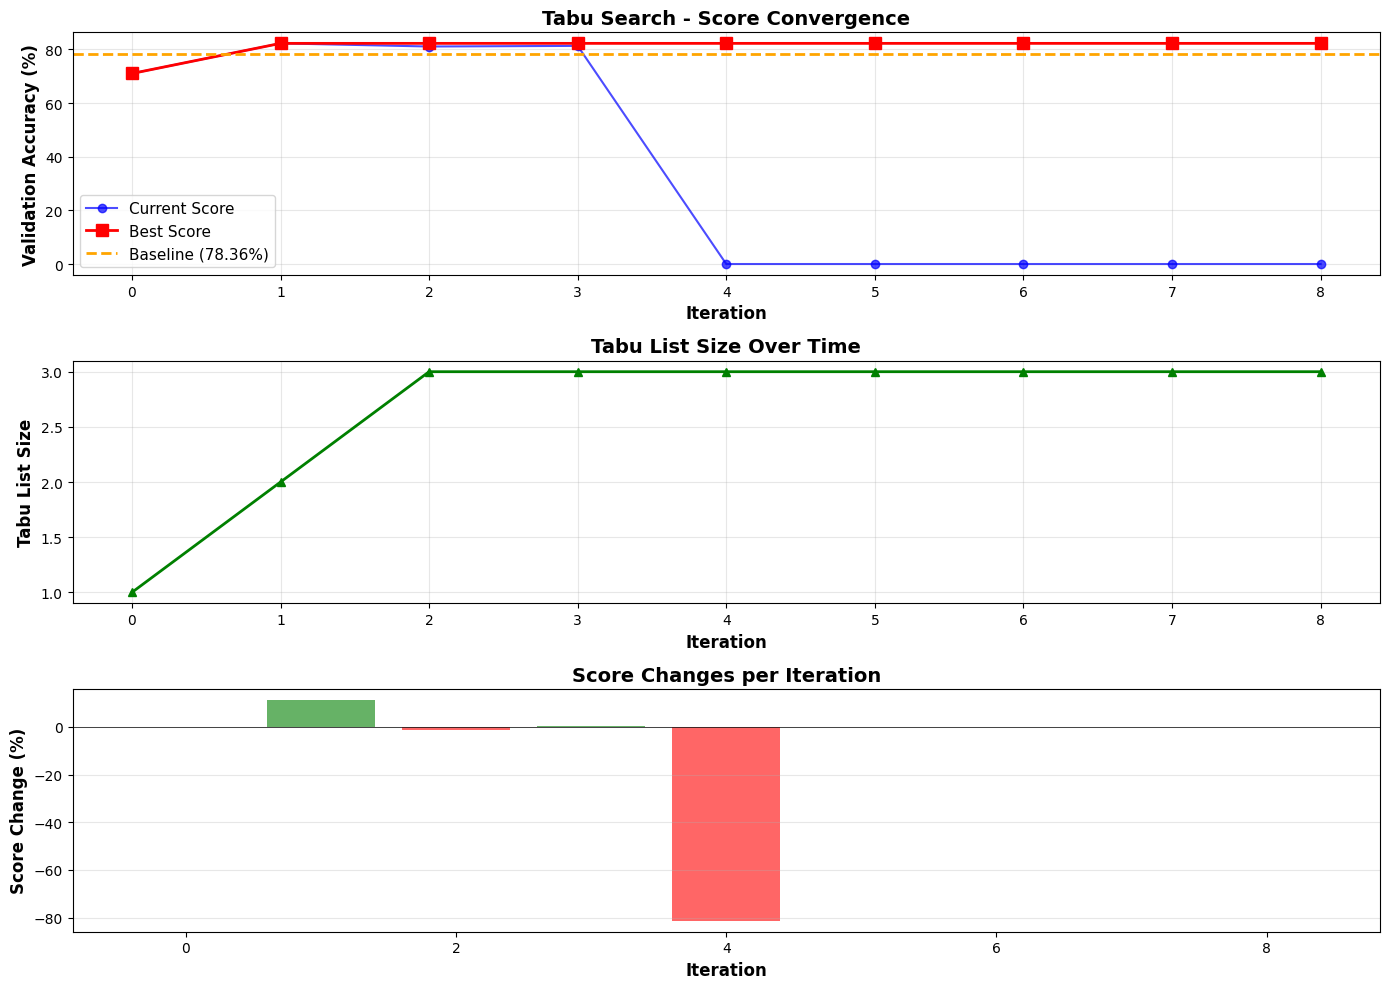

In [27]:
# Plot convergence
tabu_optimizer.plot_convergence(baseline_score=baseline_score, 
                               save_path='/kaggle/working/tabu_convergence.png')

TRAIN FINAL MODEL


 Model created
 Total parameters: 528,436

 Starting training with batch_size=16...
 Mixed precision enabled (saves GPU memory)

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 141ms/step - accuracy: 0.5328 - loss: 3.8736 - val_accuracy: 0.2585 - val_loss: 3.0493 - learning_rate: 0.0085
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.6354 - loss: 1.5447 - val_accuracy: 0.4246 - val_loss: 1.8888 - learning_rate: 0.0085
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.6361 - loss: 1.4051 - val_accuracy: 0.4000 - val_loss: 1.8885 - learning_rate: 0.0085
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.6508 - loss: 1.3842 - val_accuracy: 0.3544 - val_loss: 1.7452 - learning_rate: 0.0085
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.6534 - loss: 1.2907 - val_accuracy: 0.4643 - val_loss: 1.5931 - learning_rate: 0.0085
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.6502 - loss: 1.2825 - val_accur

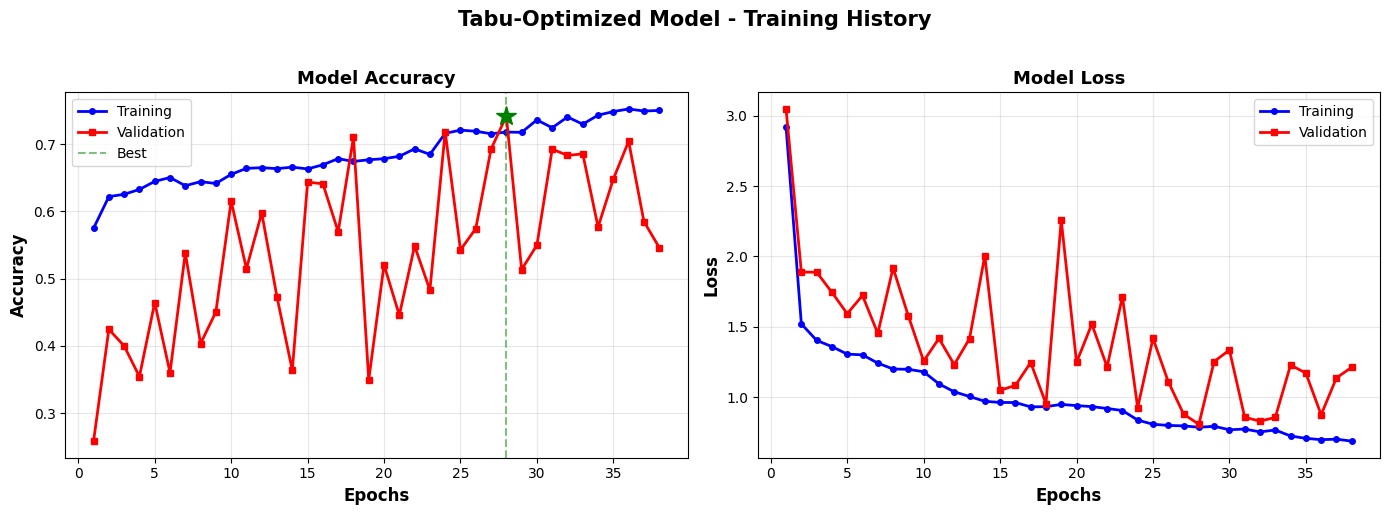


 Best Validation Accuracy: 74.15% at epoch 28


In [39]:
tabu_model = create_cnn_model(
    filters=[best_tabu_params['filter1'], best_tabu_params['filter2'], best_tabu_params['filter3']],
    dropout_rate=best_tabu_params['dropout_rate'],
    l2_reg=best_tabu_params['l2_reg'],
    dense_units=best_tabu_params['dense_units'],
    use_global_pooling=True
)

print("\n Model created")
print(f" Total parameters: {tabu_model.count_params():,}\n")

# Train with mixed precision (saves memory)
print(" Starting training with batch_size=16...")
try:
    # Enable mixed precision for memory efficiency
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(" Mixed precision enabled (saves GPU memory)\n")
except:
    print(" Mixed precision not available, continuing normally\n")

tabu_history, tabu_val_acc, tabu_time, tabu_epoch = train_and_evaluate(
    tabu_model,
    train,
    val,
    learning_rate=best_tabu_params['learning_rate'],
    optimizer_type='adam',
    epochs=50,
    patience=10,
    verbose=1
)

print(f"\n SUCCESS! Training completed!")
print(f" Final validation accuracy: {tabu_val_acc*100:.2f}% at epoch {tabu_epoch}")
print(f" Training time: {tabu_time/60:.2f} minutes")

if baseline_score:
    improvement = (tabu_val_acc - baseline_score) / baseline_score * 100
    print(f" Improvement over baseline: {improvement:+.2f}%")

plot_training_history(tabu_history, "Tabu-Optimized Model - Training History")

EVALUATE ON TEST SET

EVALUATING TABU-OPTIMIZED MODEL

 Test Accuracy: 70.48%
 Test Loss: 0.7913
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.7903    0.4900    0.6049       300
  meningioma     0.5534    0.3725    0.4453       306
     notumor     0.7885    0.9111    0.8454       405
   pituitary     0.6519    0.9800    0.7830       300

    accuracy                         0.7048      1311
   macro avg     0.6960    0.6884    0.6696      1311
weighted avg     0.7028    0.7048    0.6827      1311

PER-CLASS ACCURACY
  glioma         : 49.00% (147/300)
  meningioma     : 37.25% (114/306)
  notumor        : 91.11% (369/405)
  pituitary      : 98.00% (294/300)


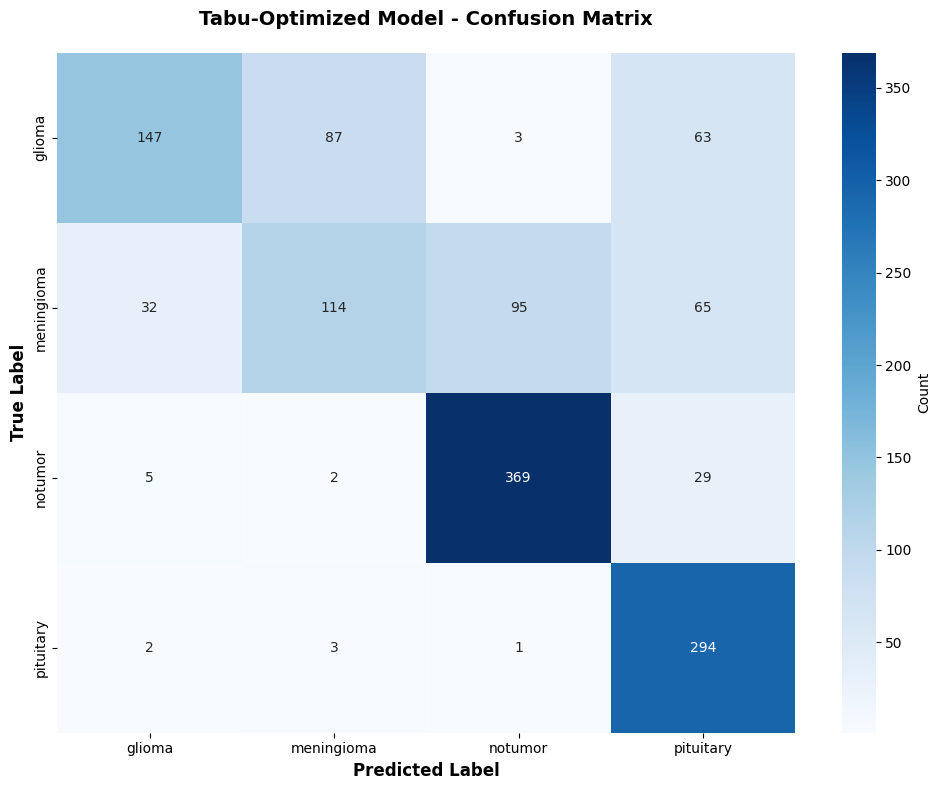

In [40]:
class_names = list(train.class_indices.keys())
tabu_results = evaluate_model(tabu_model, test, class_names, "Tabu-Optimized Model")
plot_confusion_matrix(tabu_results['confusion_matrix'], 
                     class_names, "Tabu-Optimized Model - Confusion Matrix")

SAVE MODELS AND RESULTS

In [42]:
print("SAVING MODELS AND RESULTS")
tabu_model.save('/kaggle/working/tabu_optimized_model.keras')
print(" Tabu-optimized model saved as: /kaggle/working/tabu_optimized_model.keras")

# Save best parameters
params_to_save = {}
for key, value in best_tabu_params.items():
    if isinstance(value, (np.integer, np.floating)):
        params_to_save[key] = float(value)
    else:
        params_to_save[key] = value

with open('/kaggle/working/tabu_best_parameters.json', 'w') as f:
    json.dump(params_to_save, f, indent=2)
print(" Best parameters saved as: /kaggle/working/tabu_best_parameters.json")

# Save optimization history
tabu_history_dict = {
    'optimization': {
        'iterations': tabu_optimizer.history['iteration'],
        'current_scores': [float(s) for s in tabu_optimizer.history['current_score']],
        'best_scores': [float(s) for s in tabu_optimizer.history['best_score']],
        'move_types': tabu_optimizer.history['move_type'],
        'tabu_sizes': tabu_optimizer.history['tabu_size']
    },
    'training': {
        'accuracy': [float(x) for x in tabu_history.history['accuracy']],
        'val_accuracy': [float(x) for x in tabu_history.history['val_accuracy']],
        'loss': [float(x) for x in tabu_history.history['loss']],
        'val_loss': [float(x) for x in tabu_history.history['val_loss']]
    }
}

with open('/kaggle/working/tabu_optimization_history.json', 'w') as f:
    json.dump(tabu_history_dict, f, indent=2)
print(" Optimization history saved as: /kaggle/working/tabu_optimization_history.json")

# Save results summary
tabu_results_summary = {
    'optimization': {
        'algorithm': 'Tabu Search',
        'max_iterations': tabu_optimizer.max_iter,
        'neighborhood_size': tabu_optimizer.neighborhood_size,
        'tabu_tenure': tabu_optimizer.tabu_tenure,
        'aspiration': tabu_optimizer.aspiration,
        'best_val_accuracy_during_search': float(best_tabu_score),
        'best_parameters': params_to_save
    },
    'final_model': {
        'test_accuracy': float(tabu_results['accuracy']),
        'test_loss': float(tabu_results['loss']),
        'val_accuracy': float(tabu_val_acc),
        'best_epoch': int(tabu_epoch),
        'training_time_seconds': float(tabu_time)
    },
    'class_names': class_names
}

if baseline_available and baseline_score:
    tabu_results_summary['baseline_comparison'] = {
        'baseline_test_accuracy': float(baseline_test_results['accuracy']),
        'baseline_val_accuracy': float(baseline_score),
        'test_accuracy_improvement': float(tabu_results['accuracy'] - baseline_test_results['accuracy']),
        'test_accuracy_improvement_percent': float((tabu_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100),
        'val_accuracy_improvement': float(tabu_val_acc - baseline_score),
        'val_accuracy_improvement_percent': float((tabu_val_acc - baseline_score) / baseline_score * 100)
    }

with open('/kaggle/working/tabu_results_summary.json', 'w') as f:
    json.dump(tabu_results_summary, f, indent=2)
print(" Results summary saved as: /kaggle/working/tabu_results_summary.json")

if baseline_available and baseline_score:
    comparison.to_csv('/kaggle/working/model_comparison.csv', index=False)
    print(" Model comparison saved as: /kaggle/working/model_comparison.csv")

SAVING MODELS AND RESULTS
 Tabu-optimized model saved as: /kaggle/working/tabu_optimized_model.keras
 Best parameters saved as: /kaggle/working/tabu_best_parameters.json
 Optimization history saved as: /kaggle/working/tabu_optimization_history.json
 Results summary saved as: /kaggle/working/tabu_results_summary.json
 Model comparison saved as: /kaggle/working/model_comparison.csv


FINAL SUMMARY

In [44]:
print(f"\nBest Hyperparameters Found:")
for param, value in best_tabu_params.items():
    if isinstance(value, float):
        print(f"  {param:15s}: {value:.6f}")
    else:
        print(f"  {param:15s}: {value}")

print(f"\nTabu Search Statistics:")
print(f"  Neighborhood Size: {tabu_optimizer.neighborhood_size}")
print(f"  Tabu Tenure:       {tabu_optimizer.tabu_tenure}")
print(f"  Aspiration:        {tabu_optimizer.aspiration}")

print(f"\nSaved Files:")
print(f"  - tabu_optimized_model.keras")
print(f"  - tabu_best_parameters.json")
print(f"  - tabu_optimization_history.json")
print(f"  - tabu_results_summary.json")
print(f"  - tabu_convergence.png")
if baseline_available and baseline_score:
    print(f"  - model_comparison.csv")
    print(f"  - confusion_matrix_comparison.png")
    print(f"  - per_class_comparison.png")


Best Hyperparameters Found:
  learning_rate  : 0.008458
  dropout_rate   : 0.226091
  l2_reg         : 0.002398
  filter1        : 103
  filter2        : 68
  filter3        : 384
  dense_units    : 384

Tabu Search Statistics:
  Neighborhood Size: 6
  Tabu Tenure:       3
  Aspiration:        True

Saved Files:
  - tabu_optimized_model.keras
  - tabu_best_parameters.json
  - tabu_optimization_history.json
  - tabu_results_summary.json
  - tabu_convergence.png
  - model_comparison.csv
  - confusion_matrix_comparison.png
  - per_class_comparison.png
